In [1]:
#Algorithmes pour séparer les couteurs en catégories et identifier les pics de performance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as pltlines
import matplotlib.colors as colors
import math
import statsmodels.tsa.filters.hp_filter as stat

import seaborn as sns
from datetime import datetime
import time
import scipy

from importnb import Notebook #permet d'importer un notebook comme un package
with Notebook():
    from algoStatCourse import * #notre propre notebook d'analyse de densité 



In [3]:
data=pd.read_csv("10_km_Riorges.csv")

In [4]:
data.head()
len(data)

250

In [5]:
dur=data['duration']
bins = idealBins(len(dur))
print(bins)
densite = dens(dur, bins = bins) #densite est un tableau de points avec des abscisses et des ordonnées, comme un histograme
dur=dur.to_numpy() #nécessaire à l'utilisation de skdensiteLissee de notre package


12


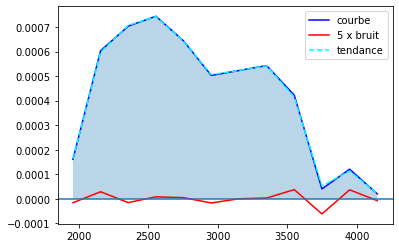

In [6]:
#Ce graphe illustre la différence entre la tendance et le bruit.
#La tendance correspond à la "loi" que suit les temps d'arrivée
#le bruit correspond aux écarts par rapport à cette loi.
#les pics de ce bruit correspondent à des volontés d'atteindre un objectif précis (- de 4h au marathon par ex)
#les vagues de la tendance correspondent à des catégories de coureurs.
brten = separate(densite)
plt.plot(brten[0],densite[1], color = "blue", label = 'courbe')
plt.plot(brten[0],5*brten[1], color = "red", label = '5 x bruit')
plt.plot(brten[0],brten[2], color = "cyan", linestyle = 'dashed',label = 'tendance')
plt.fill_between(brten[0],densite[1], alpha=0.3)
plt.axhline(0)
plt.legend()
plt.show()


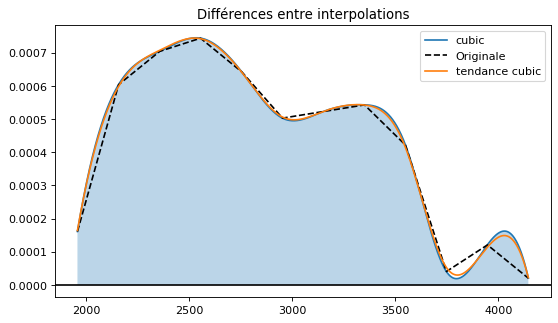

In [7]:
#on utilise une interpolation pour pouvoir calculer facilement tous les maximas et minimas locaux
#ici on peut voir l'interpolation de la tendance : une courbe "lisse". On s'en sert pour identifier les catégories de coureurs


f=lissage(densite) 
g=lissage(densite, kind = 'linear') #l'originale
h=lissage(densite, kind = 'cubic', sep=True)
i=skdensiteLissee(dur)
plt.figure(figsize=(8,4.5), dpi=80)
x=np.linspace(densite[0,0],densite[0,-1], int(1e5))
plt.fill_between(x,f(x), alpha = 0.3)
plt.plot(x,f(x), label = "cubic")
plt.plot(x,g(x), color = 'black', linestyle = 'dashed',label = "Originale")
plt.plot(x,h(x), label = "tendance cubic")
#plt.plot(x,i(x), label = "Sklearn Kernel Density")
plt.axhline(0, color='black')
plt.legend()
plt.title('Différences entre interpolations')
plt.show()

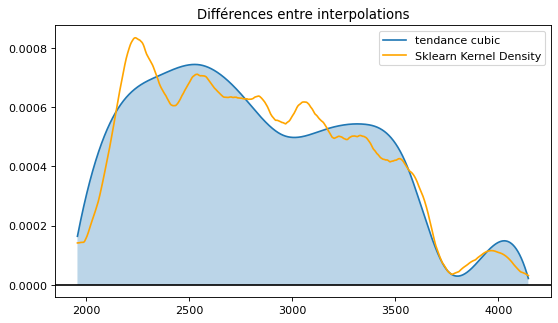

In [8]:
#Notre nouvelle fonction (donnée par Sklearn Kernel Density) est tracée en orange sur ce graphe.
#elle a été obtenur par la methode d'Epanechnikov avec une bandwidth de 150.  


h=lissage(densite, kind = 'cubic', sep=True)
i=skdensiteLissee(dur)
plt.figure(figsize=(8,4.5), dpi=80)

x=np.linspace(densite[0,0],densite[0,-1], int(1e5))
plt.fill_between(x,h(x), alpha = 0.3)

plt.plot(x,h(x), label = "tendance cubic")
plt.plot(x,i(x), label = "Sklearn Kernel Density", color='orange')
plt.axhline(0, color='black')
plt.legend()
plt.title('Différences entre interpolations')
plt.show()

In [9]:
#Avoir les densités sous forme de fonction plutôt que tableaux de points permet de calculer leurs intégrales:
#on voit que l'interpolation garde la propriété d'avoir une intégrale de 1 (à epsilon près).

#test de fonctionnement 1: densite orginale
print(scipy.integrate.quad(lambda x : lissage(densite,sep=False, kind = 'linear')(x),densite[0][0], densite[0][-1]))
# (0.9819998389448525, 1.329241666736536e-07) pour la 10km de Riorges avec un certain lambda dans le hp filter
#l'interpolation linéaire fait lever un warning lors de l'intégration car elle est affine par morceaux.

#test de fonctionnement2: tendance de la densite interpolee 
print(scipy.integrate.quad(lambda x: lissage(densite, sep = True)(x),densite[0][0], densite[0][-1]))
#(0.9925168327790789, 6.901821989123772e-09) pour la 10km de Riorges avec un certain lambda dans le hp filter

#l'interpolation cubique d'une fonction lissée donne une intégrale proche de 1 à 1e-2 pres, c'est satisfaisant.

C:\Users\tayoy\AppData\Local\Temp/ipykernel_6244/1132036512.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  print(scipy.integrate.quad(lambda x : lissage(densite,sep=False, kind = 'linear')(x),densite[0][0], densite[0][-1]))


(0.9819998389448525, 1.329241666736536e-07)
(1.001366979068995, 1.3286053996873695e-08)


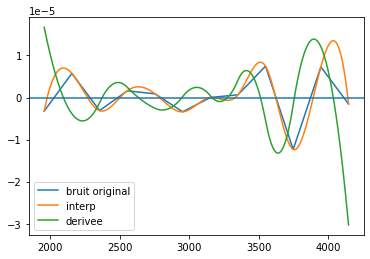

In [10]:
#Dans ce bloc, on utilise le même procédé, mais cette fois un calcule aussi les dérivées du bruit pour trouver ses maxima
# les maxima du bruit seront les "pics de performance"
x= np.linspace(brten[0,0],brten[0,-1], int(1e5)) # abscisses du tracé

poly = scipy.interpolate.splrep(brten[0],brten[1]) #interpolation polynomiale par morceaux
def f0(x):
    return scipy.interpolate.splev(x, poly, der = 0) #fonction de bruit interpolee
def f1(x):
    return 1e2*scipy.interpolate.splev(x, poly, der = 1) #derivee de la fonction de bruit
def f2(x):
    return 1e2*scipy.interpolate.splev(x, poly, der = 2) #derivee seconde (pour tests de concavite)
bruit = brten[0:2,:]

g = lissage (bruit, sep=False, kind = 'linear')

h0 = f0(x)
h1 = f1(x)
plt.plot(x, g(x), label = 'bruit original')
plt.plot(x,h0, label = 'interp')
plt.plot(x,h1, label = 'derivee')
plt.legend()
plt.axhline(0)


racines : [2095.51243121 2095.51241616 2373.63031415 2634.47396146 2634.47397737
 2947.78621198 3163.22673466 3276.26508371 3512.29949667 3756.10534916
 3163.22672539 4035.94391598]
floor : [2948.0, 4036.0, 2374.0, 2634.0, 3276.0, 3756.0, 2096.0, 3512.0, 3163.0]
sorted : [2096.0, 2374.0, 2634.0, 2948.0, 3163.0, 3276.0, 3512.0, 3756.0, 4036.0]
Comparaison : 2156.375 , 2096.0
Comparaison : 2554.208333333333 , 2634.0
Comparaison : 3150.958333333333 , 3163.0
Comparaison : 3548.7916666666665 , 3512.0
Comparaison : 3946.625 , 4036.0
pics : [2156.375, 2554.208333333333, 3150.958333333333, 3548.7916666666665, 3946.625]


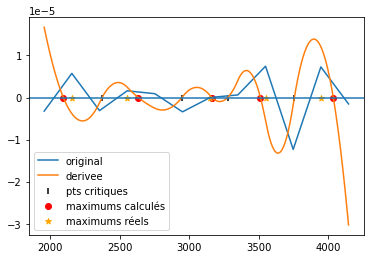

In [11]:
# ce bloc illustre comment on retrouve les maxima du bruit. On prend les maxima de l'interpolation du bruit,
#puis on choisit les points d'abscisse réelle les plus proches, car les maxima réels sont en ces points.
#la sélection des "bons" points de maximum est plus stricte (doublons, hors bornes,...)dans la fonction perfgoals qui a la même logique qu'ici

guess = densite[0] #on s'attend à ce que les racines de f1 soient proches des abscisses originales, puisque les maxima originaux en font partie

roots = scipy.optimize.root(f1, guess).x #trouve les points critiques de f
print(f"racines : {roots}")
#Les algorithmes de racines trouvent plusieurs fois les mêmes racines, à epsilon près. Supression des doublons:
roots = list(set(np.rint(roots))) #rint (entier le plus proche) permet de se limiter aux valeurs entières et eliminer les doublons dûs à scipy.optimize.root
print(f"floor : {roots}")
roots=sorted(roots)
print((f"sorted : {roots}"))

tops = [] #selection des valeurs où f est concave : les maximums
for i in range (len(roots)):
    if f2(roots[i])<0:
        tops.append(roots[i])
        
realTops = [] #valeur réelle la plus proche 
for i in tops:
    ind=np.argmin(abs(densite[0]-i))
    print(f'Comparaison : {densite[0,ind]} , {i}')
    realTops=realTops+[densite[0, ind]]

    

plt.plot(brten[0], brten[1], label = 'original')
#plt.plot(x,h0, label = 'interp')
plt.plot(x,h1, label = 'derivee')
plt.scatter(roots, [0]*len(roots), marker = '|', color = 'black', label = 'pts critiques')
plt.scatter(tops, [0]*len(tops), marker = 'o', color = 'red', label = 'maximums calculés')
plt.scatter(realTops, [0]*len(realTops),marker = '*', color = 'orange', label = "maximums réels")
plt.axhline(0)
plt.legend()

print(f'pics : {realTops}')




In [12]:
perf=perfgoals(densite)


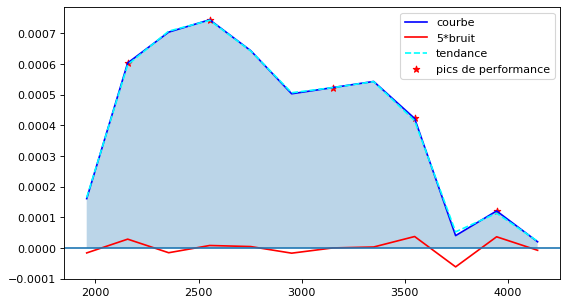

In [13]:
# Dans ce bloc, on affiche une densité avec les pics de performance (maxima du bruit). Ils sont bien visibles sur les marathons.
plt.figure(figsize=(8,4.5), dpi=80)
plt.plot(brten[0],densite[1], color = "blue", label = 'courbe')
plt.plot(brten[0],5*brten[1], color = "red", label = '5*bruit')
plt.plot(brten[0],brten[2], color = "cyan", linestyle = 'dashed',label = 'tendance')
plt.fill_between(brten[0],densite[1], alpha=0.3)
plt.axhline(0)
plt.scatter(perf[0], perf[1], color='red', marker='*', label = "pics de performance")
plt.legend()
plt.show()

In [14]:
tops, botts = topbotts(densite, sort = 'performance')
lim = limiters(densite, sort='performance')

[(1957.4583333333333, 3010.0), (3010.0, 3801.0), (3801.0, 4145.541666666666)]


catégorie 1 : (1957.4583333333333, 3010.0)
catégorie 2 : (3010.0, 3801.0)
catégorie 3 : (3801.0, 4145.541666666666)


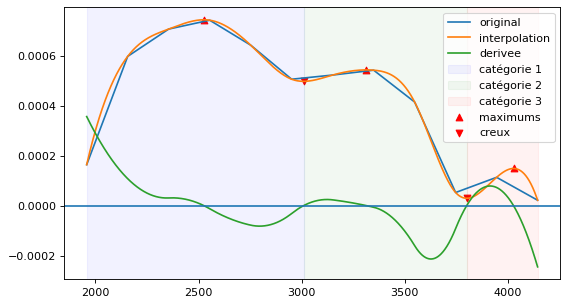

In [15]:
#les catégories de coureurs sont différenciés par les bosses et les creux de la tendance de la densité.
#Cet algorithme de détection n'a pas de sens statistique, mais tente de reproduire le jugé de l'oeil humain.
#une catégorie de coureurs correspond à une partie des coureurs qui se différencient des autres.
#Un pic de performance est un écart positif à la loi de distribution, qui correspond aux initiatives de chacun.

plt.figure(figsize=(8,4.5), dpi=80)
plt.plot(brten[0], brten[2], label = 'original')

poly=scipy.interpolate.splrep(brten[0],brten[2])
def f0 (x):
    return scipy.interpolate.splev(x,poly, der = 0)
def f1 (x):
    return 1e2*scipy.interpolate.splev(x,poly, der = 1)
def f2 (x):
    return 1e2*scipy.interpolate.splev(x,poly, der = 2)

plt.plot(x,f0(x), label = 'interpolation')
plt.plot(x,f1(x), label = 'derivee')

plt.scatter(tops, f0(tops), marker = '^', color = 'red', label = 'maximums')
plt.scatter(botts, f0(botts),marker = 'v', color = 'red', label = "creux")

cols = list(colors.BASE_COLORS.values())
for i in range(len(lim)):
    print(f'catégorie {i+1} : {lim[i]}')
    plt.axvspan(lim[i][0], lim[i][1], alpha = 0.05, color = cols[i], label = f'catégorie {i+1}')
    
plt.axhline(0)
plt.legend(loc='upper right')

In [16]:
taille_categorie(densite,lim[0])  #trouver la proportieons de coureurs dans la première catégorie 

0.64

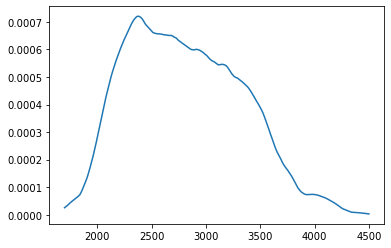

In [18]:
#Ce bloc permet de tester la sensibilité du paramètre bandwidth lors de la détermination de la densité
# 150 semble idéal (pour cette course), 50 trop petit, 300 trop élevé... Faire les tests.
# tester aussi “scott”, “silverman” pour les méthodes de calcul de bandwidth optimal.

kcourse = KernelDensity(kernel='epanechnikov', bandwidth=300) 
b=kcourse.fit(dur.reshape(-1,1))
x_plot=np.linspace(1700,4500,int(1e3))

plt.plot(x_plot,np.exp(b.score_samples(x_plot.reshape(-1,1))))